# 📝 Celda 1 — Cargar datos escalados y helpers

Leemos processed_scaled.csv (Cuaderno 2), fijamos semillas, y definimos utilidades para listar columnas por ticker y construir el objetivo Close(t+1).

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import json
import random

# Reproducibilidad
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

DATA_SCALED = Path("../data/processed/processed_scaled.csv")
df = pd.read_csv(DATA_SCALED, index_col=0, parse_dates=True).sort_index()

def cols_for(df: pd.DataFrame, ticker: str) -> list[str]:
    suf = f"_{ticker}"
    return [c for c in df.columns if c.endswith(suf)]

# Celda 1 — alternativa horizonte h=5 (precio)
HORIZON = 5
def build_xy_for(df: pd.DataFrame, ticker: str):
    cols = cols_for(df, ticker)
    features = [c for c in cols if ("Dividends_" not in c and "StockSplits_" not in c)]
    X = df[features].copy()
    y = df[f"Close_{ticker}"].shift(-HORIZON)  # t+HORIZON
    data = X.join(y.rename("y")).dropna()
    return data[features], data["y"]


print("Shape total:", df.shape, "| rango:", df.index.min().date(), "→", df.index.max().date())
print("Ejemplo cols BBVA:", cols_for(df, "BBVA")[:5])
print("Ejemplo cols SAN :", cols_for(df, "SAN")[:5])


Shape total: (6615, 30) | rango: 2000-01-28 → 2025-10-30
Ejemplo cols BBVA: ['Close_BBVA', 'Volume_BBVA', 'Open_BBVA', 'High_BBVA', 'Low_BBVA']
Ejemplo cols SAN : ['Close_SAN', 'Volume_SAN', 'Open_SAN', 'High_SAN', 'Low_SAN']


# 📝 Celda 2 — Split temporal: train / val / test

Creamos un split temporal 70% / 10% / 20% (idéntico espíritu al TFG para disponer de validación durante el entrenamiento). No barajamos.

In [2]:
from typing import Tuple

def temporal_split_3(X: pd.DataFrame, y: pd.Series,
                     ratios=(0.7, 0.1, 0.2)) -> Tuple[tuple, tuple, tuple, dict]:
    a,b,c = ratios
    assert abs(a+b+c-1.0) < 1e-8, "Ratios deben sumar 1."
    n = len(X)
    i1 = int(n*a)
    i2 = int(n*(a+b))
    Xtr, ytr = X.iloc[:i1], y.iloc[:i1]
    Xva, yva = X.iloc[i1:i2], y.iloc[i1:i2]
    Xte, yte = X.iloc[i2:], y.iloc[i2:]
    idx = {"i_train_end": i1, "i_val_end": i2, "n": n}
    return (Xtr, ytr), (Xva, yva), (Xte, yte), idx

(Xb, yb) = build_xy_for(df, "BBVA")
(Xs, ys) = build_xy_for(df, "SAN")

(bb_tr, bb_va, bb_te, bb_idx) = temporal_split_3(Xb, yb)
(sn_tr, sn_va, sn_te, sn_idx) = temporal_split_3(Xs, ys)

for name, (Xy_tr, Xy_va, Xy_te, info) in {
    "BBVA": (bb_tr, bb_va, bb_te, bb_idx),
    "SAN" : (sn_tr, sn_va, sn_te, sn_idx)
}.items():
    print(f"{name} => train {Xy_tr[0].shape}, val {Xy_va[0].shape}, test {Xy_te[0].shape} | cortes {info}")


BBVA => train (4629, 13), val (662, 13), test (1323, 13) | cortes {'i_train_end': 4629, 'i_val_end': 5291, 'n': 6614}
SAN => train (4629, 13), val (662, 13), test (1323, 13) | cortes {'i_train_end': 4629, 'i_val_end': 5291, 'n': 6614}


In [ ]:
# Celda 2bis — Escalado sin fuga (fit en train)
from sklearn.preprocessing import MinMaxScaler

def fit_scaler_on_train(X_train: pd.DataFrame) -> MinMaxScaler:
    sc = MinMaxScaler()
    sc.fit(X_train)  # SOLO estadísticas del train
    return sc

def apply_scaler(sc: MinMaxScaler, X: pd.DataFrame) -> pd.DataFrame:
    Xs = X.copy()
    Xs[X.columns] = sc.transform(X)
    return Xs

# Escalamos por TICKER de forma separada
(Xb, yb) = build_xy_for(df, "BBVA")   # viene de Celda 1
(Xs, ys) = build_xy_for(df, "SAN")

(bb_tr, bb_va, bb_te, bb_idx) = temporal_split_3(Xb, yb)  # Celda 2
(sn_tr, sn_va, sn_te, sn_idx) = temporal_split_3(Xs, ys)

# BBVA
sc_bbva = fit_scaler_on_train(bb_tr[0])
bb_tr_s = (apply_scaler(sc_bbva, bb_tr[0]), bb_tr[1])
bb_va_s = (apply_scaler(sc_bbva, bb_va[0]), bb_va[1])
bb_te_s = (apply_scaler(sc_bbva, bb_te[0]), bb_te[1])

# SAN
sc_san = fit_scaler_on_train(sn_tr[0])
sn_tr_s = (apply_scaler(sc_san, sn_tr[0]), sn_tr[1])
sn_va_s = (apply_scaler(sc_san, sn_va[0]), sn_va[1])
sn_te_s = (apply_scaler(sc_san, sn_te[0]), sn_te[1])


# 📝 Celda 3 — Función de windowing (sliding windows)

Construimos secuencias 3D de forma causal: cada muestra usa los últimos W pasos como entrada y el objetivo es el valor siguiente (ya lo preparamos como y=Close(t+1), por lo que alineamos la última fila de la ventana con el índice de y).

In [3]:
def build_windows(X_df: pd.DataFrame, y_sr: pd.Series, window_size: int):
    Xv = X_df.values  # (N, F)
    yv = y_sr.values  # (N,)
    N, F = Xv.shape
    W = window_size
    # Generamos pares (i -> ventana X[i-W+1:i+1], y[i]) empezando en i=W-1
    xs = []
    ys = []
    idx = []
    for i in range(W-1, N):
        xs.append(Xv[i-W+1:i+1, :])  # (W, F)
        ys.append(yv[i])             # escalar
        idx.append(X_df.index[i])    # fecha de la etiqueta
    X3 = np.stack(xs, axis=0)        # (samples, W, F)
    y1 = np.array(ys, dtype=np.float32)
    idx = pd.DatetimeIndex(idx)
    return X3.astype(np.float32), y1, idx

# Prueba rápida
Xtrial, ytrial, idtrial = build_windows(bb_tr[0], bb_tr[1], window_size=10)
print("Trial BBVA W=10:", Xtrial.shape, ytrial.shape, "| ejemplo idx:", idtrial[:3])


Trial BBVA W=10: (4620, 10, 13) (4620,) | ejemplo idx: DatetimeIndex(['2000-02-10', '2000-02-11', '2000-02-14'], dtype='datetime64[ns]', freq=None)


# 📝 Celda 4 — Generar datasets (BBVA y SAN) para W ∈ {10, 20, 30}

Creamos las matrices 3D para train, val y test por cada window_size y ticker. Guardamos en un diccionario para inspección rápida.

In [ ]:
# Celda 4 — usa los splits escalados sin fuga
WINDOWS = [10, 20, 30]
datasets = {"BBVA": {}, "SAN": {}}

def make_all_splits(Xy_tr, Xy_va, Xy_te, window_size: int):
    (Xtr, ytr) = Xy_tr
    (Xva, yva) = Xy_va
    (Xte, yte) = Xy_te
    Xtr3, ytr1, idx_tr = build_windows(Xtr, ytr, window_size)
    Xva3, yva1, idx_va = build_windows(Xva, yva, window_size)
    Xte3, yte1, idx_te = build_windows(Xte, yte, window_size)
    return {"train": (Xtr3, ytr1, idx_tr),
            "val":   (Xva3, yva1, idx_va),
            "test":  (Xte3, yte1, idx_te),
            "n_features": Xtr.shape[1]}

for W in WINDOWS:
    datasets["BBVA"][W] = make_all_splits(bb_tr_s, bb_va_s, bb_te_s, W)
    datasets["SAN"][W]  = make_all_splits(sn_tr_s, sn_va_s, sn_te_s, W)



BBVA W=10 → train(4620, 10, 13), val(653, 10, 13), test(1314, 10, 13), features=13
BBVA W=20 → train(4610, 20, 13), val(643, 20, 13), test(1304, 20, 13), features=13
BBVA W=30 → train(4600, 30, 13), val(633, 30, 13), test(1294, 30, 13), features=13
SAN W=10 → train(4620, 10, 13), val(653, 10, 13), test(1314, 10, 13), features=13
SAN W=20 → train(4610, 20, 13), val(643, 20, 13), test(1304, 20, 13), features=13
SAN W=30 → train(4600, 30, 13), val(633, 30, 13), test(1294, 30, 13), features=13


# 📝 Celda 5 — Guardar a disco (NPY + metadatos)

Guardamos en ../data/processed/seq/{ticker}/w{W}/ los arrays X_train.npy, y_train.npy, X_val.npy, y_val.npy, X_test.npy, y_test.npy y un meta.json con formas y columnas.

In [5]:
OUT = Path("../data/processed/seq")
OUT.mkdir(parents=True, exist_ok=True)

def save_split(base: Path, split_name: str, X3: np.ndarray, y1: np.ndarray, idx: pd.DatetimeIndex):
    np.save(base / f"X_{split_name}.npy", X3)
    np.save(base / f"y_{split_name}.npy", y1)
    # Guardamos las fechas de las etiquetas por trazabilidad
    pd.Series(idx, name="date").to_csv(base / f"idx_{split_name}.csv", index=False)

for tkr in ["BBVA", "SAN"]:
    feat_cols = [c for c in cols_for(df, tkr) if ("Dividends_" not in c and "StockSplits_" not in c)]
    for W in WINDOWS:
        base = OUT / f"{tkr}" / f"w{W}"
        base.mkdir(parents=True, exist_ok=True)
        for split in ["train", "val", "test"]:
            X3, y1, idx = datasets[tkr][W][split]
            save_split(base, split, X3, y1, idx)
        meta = {
            "ticker": tkr,
            "window_size": W,
            "n_features": len(feat_cols),
            "features": feat_cols,
            "shapes": {
                s: list(datasets[tkr][W][s][0].shape) for s in ["train","val","test"]
            },
            "index_range": {
                s: [str(datasets[tkr][W][s][2].min().date()), str(datasets[tkr][W][s][2].max().date())]
                if len(datasets[tkr][W][s][2])>0 else None
                for s in ["train","val","test"]
            }
        }
        with open(base / "meta.json", "w", encoding="utf-8") as f:
            json.dump(meta, f, indent=2, ensure_ascii=False)
        print(f"✅ Guardado {tkr} W={W} en {base}")


✅ Guardado BBVA W=10 en ..\data\processed\seq\BBVA\w10
✅ Guardado BBVA W=20 en ..\data\processed\seq\BBVA\w20
✅ Guardado BBVA W=30 en ..\data\processed\seq\BBVA\w30
✅ Guardado SAN W=10 en ..\data\processed\seq\SAN\w10
✅ Guardado SAN W=20 en ..\data\processed\seq\SAN\w20
✅ Guardado SAN W=30 en ..\data\processed\seq\SAN\w30


# 📝 Celda 6 — Sanity check visual (una muestra al azar)

Comprobamos que una ventana realmente termina en el día inmediatamente anterior a la etiqueta (porque y = Close(t+1)). Mostramos la última feature Close de la ventana y el y correspondiente.

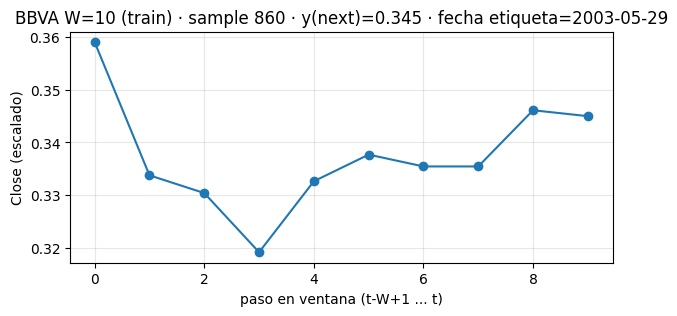

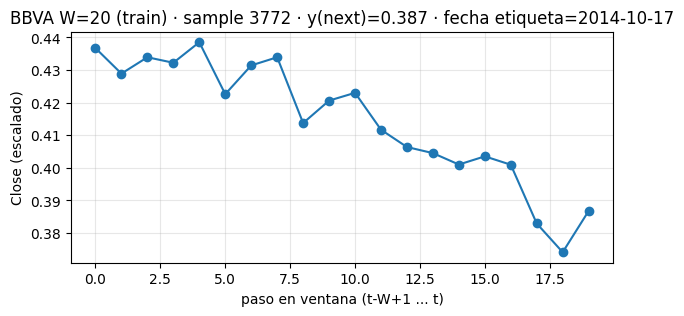

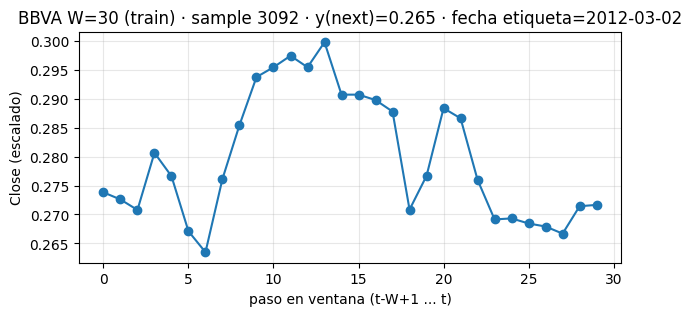

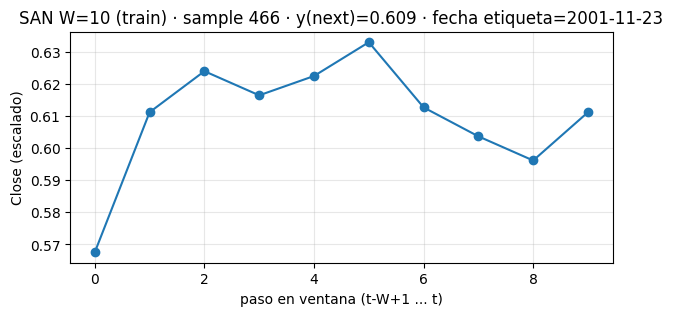

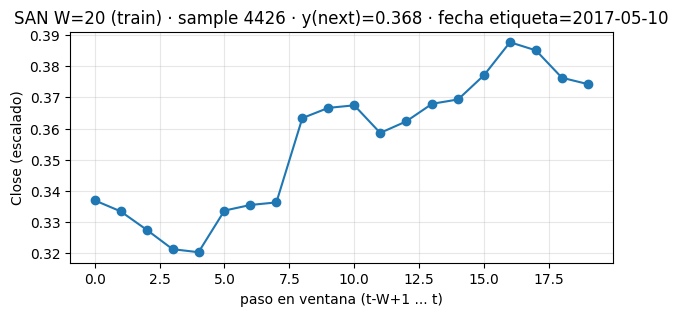

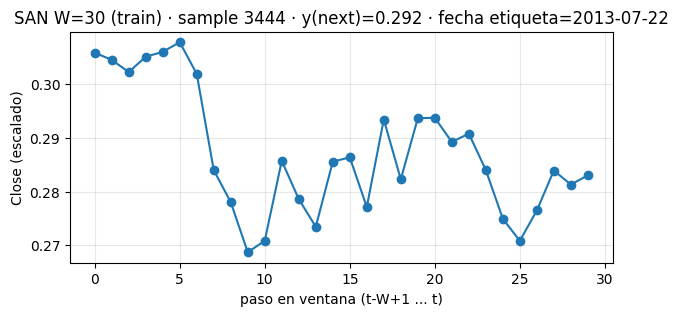

In [6]:
import matplotlib.pyplot as plt

def sanity_plot_one(dset, title):
    X3, y1, idx = dset
    i = np.random.randint(0, len(X3))
    close_series = X3[i, :, 0]  # OJO: asumimos que la 1ª columna de features es Close_* (lo es con nuestro orden)
    plt.figure(figsize=(7,3))
    plt.plot(range(len(close_series)), close_series, marker='o')
    plt.title(f"{title} · sample {i} · y(next)={y1[i]:.3f} · fecha etiqueta={idx[i].date()}")
    plt.xlabel("paso en ventana (t-W+1 ... t)"); plt.ylabel("Close (escalado)")
    plt.grid(alpha=0.3); plt.show()

# Dibujamos una muestra de cada ticker/ventana desde el split de entrenamiento
for tkr in ["BBVA", "SAN"]:
    for W in [10, 20, 30]:
        sanity_plot_one(datasets[tkr][W]["train"], f"{tkr} W={W} (train)")


# 📝 Celda 7 — Resumen tabular de shapes

Tabla rápida con las formas de los arrays por ticker y ventana (útil para el informe y para verificar tamaños antes del Cuaderno 5).

In [7]:
rows = []
for tkr in ["BBVA", "SAN"]:
    for W in WINDOWS:
        tr = datasets[tkr][W]["train"][0].shape
        va = datasets[tkr][W]["val"][0].shape
        te = datasets[tkr][W]["test"][0].shape
        rows.append([tkr, W, *tr, *va, *te])
cols = ["Ticker","W","X_train","W_train","F_train","X_val","W_val","F_val","X_test","W_test","F_test"]
# Convertir tuplas en ints legibles
pretty = []
for r in rows:
    tkr, W, tr0,tr1,tr2, va0,va1,va2, te0,te1,te2 = r
    pretty.append([tkr, W, tr0, tr1, tr2, va0, va1, va2, te0, te1, te2])
summary_df = pd.DataFrame(pretty, columns=["Ticker","W","n_tr","W_tr","F_tr","n_va","W_va","F_va","n_te","W_te","F_te"])
summary_df


,Ticker,W,n_tr,W_tr,F_tr,n_va,W_va,F_va,n_te,W_te,F_te
0,BBVA,10,4620,10,13,653,10,13,1314,10,13
1,BBVA,20,4610,20,13,643,20,13,1304,20,13
2,BBVA,30,4600,30,13,633,30,13,1294,30,13
3,SAN,10,4620,10,13,653,10,13,1314,10,13
4,SAN,20,4610,20,13,643,20,13,1304,20,13
5,SAN,30,4600,30,13,633,30,13,1294,30,13


## Conclusión del Cuaderno 4

Listo el dataset secuencial para RNNs:

✅ train/val/test temporal (70/10/20) por BBVA y SAN.

✅ Ventanas W ∈ {10, 20, 30} → tensores de forma (samples, window, features).

✅ Guardado en ../data/processed/seq/{ticker}/w{W}/ con NPY + meta.json.

✅ Comprobación visual de alineación (sanity check).

¡Revisado todo, Lucía! ✅
Tus salidas del Cuaderno 4 están perfectas y en línea con lo que esperaba:

Splits temporales: BBVA/SAN → train (4629,13), val (662,13), test (1323,13) antes del ventaneo. Correcto (70/10/20 sin barajar).

Ventaneo:

W=10 → train(4620,10,13), val(653,10,13), test(1314,10,13)

W=20 → train(4610,20,13), val(643,20,13), test(1304,20,13)

W=30 → train(4600,30,13), val(633,30,13), test(1294,30,13)
La reducción de muestras (= W−1 por cada split) es la esperada.

Índices: las fechas de idx corresponden al día de la etiqueta (t+1). Correcto.

Sanity plots: muestran bien la serie de Close dentro de la ventana y el y(next) coherente.

Guardados: rutas ../data/processed/seq/{ticker}/w{W} con X/y de train/val/test y meta.json. Todo OK.